## Lung Cancer Classification using Deep Leanring


### Install dependencies

In [1]:
!pip install -q datasets transformers
!pip install accelerate
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

In [2]:
#load libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import numpy as np
import torch
from datasets import load_metric

### Main Code Begins

In [3]:
# Import wandb to log training and evaluation results
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
wandb.init(project="BEIT-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled",
           config={
               "batch_size": 16,
               "num_train_epochs": 5,
               "learning_rate": 5e-4,
               "warmup_ratio": 0.5,
               "dataset": "LC25000",
               "gradient_accumulation_steps": 4

           })

In [6]:
# Gpu Stats
!nvidia-smi

Sat Jul 22 17:32:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Connect notebook to HuggingFace hub
from huggingface_hub import notebook_login
notebook_login()

In [8]:
# Install Git-LFS to upload your model checkpoints:

%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

### Loading the dataset

In [9]:
# Load the Gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 # Uncomment this cell if unzipping the dataset
#import zipfile

#path_to_zip_file = '/content/drive/MyDrive/Lung_Colon_Cancer/Lung-Dataset-Resized.zip'
#directory_to_extract_to = '/content/drive/MyDrive/Lung_Colon_Cancer/Augmented-Final/'

#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#  zip_ref.extractall(directory_to_extract_to)

In [11]:
# Load the train/val dataset

dataset = load_dataset("/content/drive/MyDrive/Lung_Cancer/Augmented-Final/", data_dir="./Resized/")


Resolving data files:   0%|          | 0/15000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/Augmented-Final-dcdec8763aaaae5e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 15000
})

In [13]:
# Convert the class labels to an integer id
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label

{0: 'Lung-Benign_Tissue',
 1: 'Lung_Adenocarcinoma',
 2: 'Lung_Squamous_Cell_Carcinoma'}

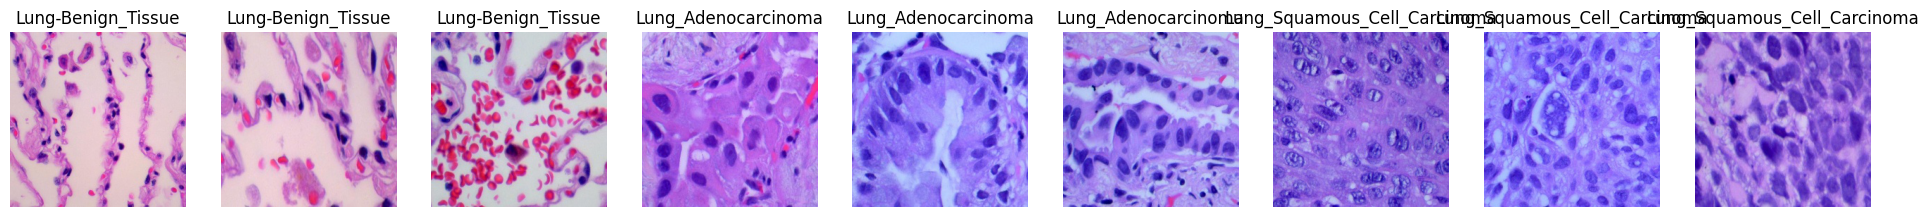

In [14]:
# Select four image from each label
samples=[dataset['train'][0],dataset['train'][2500],dataset['train'][4999]
         ,dataset['train'][5000],dataset['train'][6000],dataset['train'][9999],
         dataset['train'][10000],dataset['train'][12500],dataset['train'][14999]]

# Display the selected images
fig, ax = plt.subplots(1, len(samples),  figsize=(24, 20))
for i,row in enumerate(samples):
  ax[i].imshow(row['image'])
  ax[i].set_title(id2label[samples[i]['label']])
  ax[i].axis('off')
plt.show()

In [15]:
# Entries in the dataset loaded
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Lung-Benign_Tissue', 'Lung_Adenocarcinoma', 'Lung_Squamous_Cell_Carcinoma'], id=None)}

In [16]:
dataset["train"].features["label"]

ClassLabel(names=['Lung-Benign_Tissue', 'Lung_Adenocarcinoma', 'Lung_Squamous_Cell_Carcinoma'], id=None)

### Preprocessing the data

In [17]:

# pre-trained model checkpoint to be used for fine-tuning
model_checkpoint = "microsoft/beit-large-patch16-224"

# batch size for training and evaluation
batch_size = 16

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [18]:
# Here we define 2 separate functions, one for training and one for validation
# This is used to apply some augmentation during the training

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_test(example_batch):
    """Apply test_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [19]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.3,shuffle=True, seed=45)
test_ds = splits['test']
train_splits=splits['train'].train_test_split(test_size=0.43)
train_ds = train_splits['train']
val_ds = train_splits['test']

In [20]:
from collections import Counter
Counter(test_ds['label'])

Counter({2: 1492, 1: 1483, 0: 1525})

In [21]:
# We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_test)

In [22]:
# Single image entry
test_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x787A2021CC70>,
 'label': 2,
 'pixel_values': tensor([[[ 0.4118,  0.4039,  0.4275,  ...,  0.3176,  0.3490,  0.3804],
          [ 0.3725,  0.3882,  0.3961,  ...,  0.3020,  0.3412,  0.3647],
          [ 0.3098,  0.3569,  0.3725,  ...,  0.3020,  0.3333,  0.3647],
          ...,
          [ 0.1529,  0.2549,  0.3098,  ...,  0.4196,  0.4196,  0.3569],
          [ 0.1608,  0.2863,  0.3020,  ...,  0.4196,  0.3961,  0.3647],
          [ 0.2157,  0.2941,  0.2941,  ...,  0.3490,  0.3647,  0.3569]],
 
         [[ 0.1373,  0.1294,  0.1529,  ...,  0.1294,  0.1686,  0.2000],
          [ 0.1137,  0.1137,  0.1294,  ...,  0.1059,  0.1451,  0.1765],
          [ 0.0431,  0.0902,  0.1059,  ...,  0.0902,  0.1294,  0.1529],
          ...,
          [-0.1451, -0.0431,  0.0196,  ...,  0.2706,  0.2784,  0.2235],
          [-0.1373, -0.0118,  0.0039,  ...,  0.2392,  0.2235,  0.1922],
          [-0.0980, -0.0118, -0.0196,  ...,  0.1686, 

### Training the model

In [23]:
# Metric for assessing the trained model
metric = load_metric("accuracy")

<ipython-input-23-0940b35cbb2c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [24]:
# Load the model using it's configuration file and making the output as per the give classes


model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Congigure the Hyperparameters for the training

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.5,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [26]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)



# We also define a `collate_fn`, which will be used to batch examples together.
# Each batch consists of 2 keys, namely `pixel_values` and `labels`.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [27]:
# The trainer is the final instance ready to be trained for given model
# configurations and input data

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled into local empty directory.


In [ ]:
# To remove any folder of the model trained
# !rm -r /content/convnextv2-large-1k-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20

In [28]:
# Start the training
train_results = trainer.train()

# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.153100,0.135074,0.950609
1,0.238900,0.153410,0.934441
2,0.251700,0.148386,0.940199
4,0.176900,0.110807,0.957032
4,0.076400,0.060048,0.976523


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/1.13G [00:00<?, ?B/s]

Upload file runs/Jul22_17-36-37_6a016831cfe9/events.out.tfevents.1690047412.6a016831cfe9.2994.0:   0%|        …

To https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled
   7bc8faa..cf533f5  main -> main

   7bc8faa..cf533f5  main -> main

To https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled
   cf533f5..c26a080  main -> main

   cf533f5..c26a080  main -> main



***** train metrics *****
  epoch                    =         4.96
  total_flos               = 7579718367GF
  train_loss               =       0.2269
  train_runtime            =   2:53:35.65
  train_samples_per_second =        2.873
  train_steps_per_second   =        0.045


In [29]:
# We can check with the `evaluate` method that our `Trainer` did reload the
# best model properly (if it was not the last one):

metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       4.96
  eval_accuracy           =     0.9765
  eval_loss               =       0.06
  eval_runtime            = 0:02:52.80
  eval_samples_per_second =     26.127
  eval_steps_per_second   =      1.638


### Testing on Test Dataset

In [33]:
# Perform predictions
predictions, labels, metrics_test = trainer.predict(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  predict_accuracy           =     0.9782
  predict_loss               =     0.0553
  predict_runtime            = 0:02:53.60
  predict_samples_per_second =     25.921
  predict_steps_per_second   =      1.624


In [32]:
# Perform evaluatoin
metrics_test = trainer.evaluate(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  epoch                      =       4.96
  predict_accuracy           =     0.9782
  predict_loss               =     0.0553
  predict_runtime            = 0:02:52.88
  predict_samples_per_second =     26.029
  predict_steps_per_second   =      1.631


You can now upload the result of the training to the Hub, just execute this instruction :

In [34]:
# It allows the Trainer to push the model to the [Hub]
trainer.push_to_hub()

Upload file runs/Jul22_17-36-37_6a016831cfe9/events.out.tfevents.1690058137.6a016831cfe9.2994.1: 100%|########…

To https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled
   c26a080..e58b3a5  main -> main

   c26a080..e58b3a5  main -> main



'https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled/commit/e58b3a5173a088d2441c184a55eca9af2a7d741b'

The trained model can be loaded using the following commands

```python
from transformers import AutoModelForImageClassification, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("ahmedALM1221/convnextv2-large-1k-224-finetuned-eurosat-50")
model = AutoModelForImageClassification.from_pretrained("ahmedALM1221/convnextv2-large-1k-224-finetuned-eurosat-50")

```

# Compute metrics

In [35]:
#!pip install -q datasets transformers
#!pip install accelerate
#!pip install wandb

#load libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
# Import the image processor compatible with the given model architecture
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch
from datasets import load_metric
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import warnings

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
# Load the Gdrive

from google.colab import drive
drive.mount('/content/drive')

# Load the train/val dataset

dataset = load_dataset("/content/drive/MyDrive/Lung_Cancer/Augmented-Final/", data_dir="./Resized/")

# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.3,shuffle=True, seed=45)
test_ds = splits['test']
train_splits=splits['train'].train_test_split(test_size=0.43)
train_ds = train_splits['train']
val_ds = train_splits['test']

Mounted at /content/drive


Resolving data files:   0%|          | 0/1223 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/test-60607148d1f081b8/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# pre-trained model checkpoint to be used for fine-tuning
model_checkpoint = "ALM-AHME/beit-large-patch16-224-finetuned-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled"

# batch size for training and evaluation
batch_size = 16

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)

In [38]:
# Here we define 2 separate functions, one for training and one for validation
# This is used to apply some augmentation during the training

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_test(example_batch):
    """Apply test_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

# Convert the class labels to an integer id
labels = test_ds.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label

{0: 'Lung-Benign_Tissue',
 1: 'Lung_Adenocarcinoma',
 2: 'Lung_Squamous_Cell_Carcinoma'}

In [ ]:
test_ds.set_transform(preprocess_test)

# Metric for assessing the trained model
metric = load_metric("accuracy")


# Load the model using it's configuration file and making the output as per the give classes
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = False, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

# Congigure the Hyperparameters for the training

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-LungCancer-Classification-LC25000-AH-40-30-30-Shuffled",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.5,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)



# We also define a `collate_fn`, which will be used to batch examples together.
# Each batch consists of 2 keys, namely `pixel_values` and `labels`.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# compute all scores macro and weighted
def evaluation_summary(desc, predictions, true_labels):
    accuracy = accuracy_score(predictions, true_labels)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    f1 = fbeta_score(predictions, true_labels, beta=1, average='macro')
    weighted_precision = precision_score(predictions, true_labels, average='weighted')
    weighted_recall = recall_score(predictions, true_labels, average='weighted')
    weighted_f1 = fbeta_score(predictions, true_labels, beta=1, average='weighted')
    results = {
            "classifier": [desc],
            "accuracy": [round(accuracy,3)],
            "macro_precision": [round(precision,3)],
            "macro_recall": [round(recall,3)],
            "macro_f1": [round(f1,3)],
            "weighted_precision": [round(weighted_precision,3)],
            "weighted_recall": [round(weighted_recall,3)],
            "weighted_f1": [round(weighted_f1,3)]
            }
    return pd.DataFrame.from_dict(results)

<ipython-input-5-c648cc331c03>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
# The trainer is the final instance ready to be trained for given model
# configurations and input data
trainer = Trainer(
    model,
    args,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [43]:
# Perform predictions
predictions, labels, metrics_test = trainer.predict(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  predict_accuracy           =     0.9782
  predict_loss               =     0.0553
  predict_runtime            = 0:02:52.59
  predict_samples_per_second =     26.073
  predict_steps_per_second   =      1.634


<Axes: xlabel='Predicted Labels', ylabel='Actual Labels'>

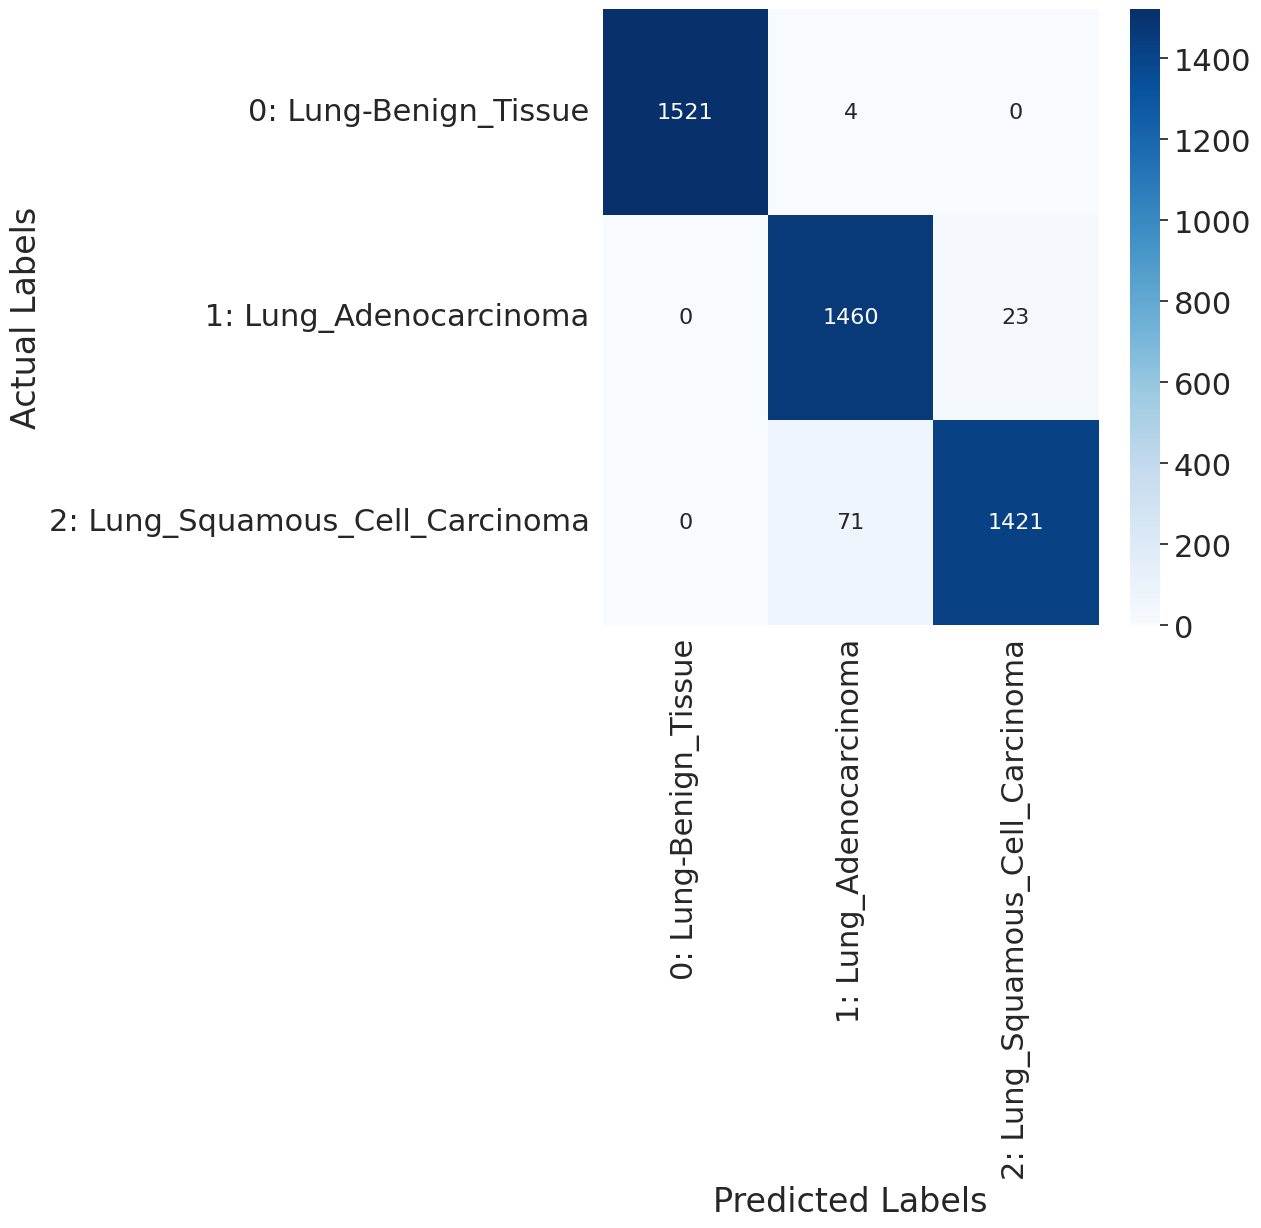

In [40]:
test_pred_labels=predictions.argmax(axis=1)

data = confusion_matrix(test_ds[:]['label'],test_pred_labels,labels=[0,1,2])
df_cm = pd.DataFrame(data, columns=['0: Lung-Benign_Tissue',' 1: Lung_Adenocarcinoma', '2: Lung_Squamous_Cell_Carcinoma'], index = ['0: Lung-Benign_Tissue',' 1: Lung_Adenocarcinoma', '2: Lung_Squamous_Cell_Carcinoma'])
df_cm.index.name = 'Actual Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (8,8))
sn.set(font_scale=2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


In [41]:
print(classification_report(test_ds[:]['label'],test_pred_labels,digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9974    0.9987      1525
           1     0.9511    0.9845    0.9675      1483
           2     0.9841    0.9524    0.9680      1492

    accuracy                         0.9782      4500
   macro avg     0.9784    0.9781    0.9781      4500
weighted avg     0.9786    0.9782    0.9782      4500



In [42]:
beit_test_result=evaluation_summary("BEIT-finetuned-LungCancer-Classification- Test data Shuffled", test_pred_labels , test_ds[:]['label'])

summary_eval = pd.concat([beit_test_result], axis=0)
summary_eval = summary_eval.reset_index(drop=True)
color = (summary_eval.weighted_f1 > 0).map({True: 'background-color: green', False: ''})
summary_eval.style.apply(lambda s: color)

,classifier,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,BEIT-finetuned-LungCancer-Classification- Test data Shuffled,0.978000,0.978000,0.978000,0.978000,0.979000,0.978000,0.978000
